# Part 2 import

Ideas used from: https://github.com/aprilypchen/depy2016


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
%matplotlib inline


# Impute missing values using Imputer in sklearn.preprocessing
from sklearn.preprocessing import Imputer, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import ShuffleSplit, train_test_split, validation_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import fbeta_score, recall_score, make_scorer

pd.options.display.max_rows = 160
pd.options.display.max_columns = 200

def plot_box_hist2(df, col, title='', **kwargs):
    '''
    Show a box plot and a histogram of the column values.
    '''
    print("Missing values for", col, df[col].isnull().sum())
    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 9), sharex=True);
    df.boxplot(ax=ax1, column=col, by='loan_status', vert=False);
    df[df['loan_status'] == 1][col].plot.hist(ax=ax2, color='r', title='Charge-off ' + title + ' (' + col + ')', **kwargs);
    df[df['loan_status'] == 0][col].plot.hist(ax=ax3, color='g', title='Good loan ' + title + ' (' + col + ')', **kwargs);
    
    plt.show()

def col_stats(df):
    nsd = pd.DataFrame()
    nsd['dtypes'] = df.dtypes
    ns = df.isnull().sum()
    #ns = ns.sort_values(ascending=False)
    nsd['Null Count'] = ns
    nsd['Null Percent'] = ns / len(df) *100
    nsd.index.name = 'columns'
    nsd.sort_values(by='Null Percent' ,inplace=True, ascending=False)

    m = df.min(0)
    m.name = 'Min'
    nsd = nsd.join(m)

    m = df.max(0)
    m.name = 'Max'
    nsd = nsd.join(m)
    nsd

    m = df.median(0)
    m.name = 'Med'
    nsd = nsd.join(m)
    nsd
    
    m = df.skew(0)
    m.name = 'Sqew'
    nsd = nsd.join(m)
    nsd

    unique_counts = []
    for col_name in nsd.index.values:
        unique_counts.append(len(df[col_name].unique()))
        #print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
    nsd['unique_counts'] = unique_counts
    return nsd

usecols1 = ['loan_status', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 
           'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 
           'zip_code', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 
           'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'emp_title',
           
           'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 
           'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 
           'mths_since_last_major_derog', 
           'application_type', 'annual_inc_joint', 'dti_joint', 
           'verification_status_joint']

usecols = ['acc_now_delinq', 
           'tot_coll_amt', 
           'tot_cur_bal', 
           'open_acc_6m', 
           'open_act_il', 
           'open_il_12m', 'open_il_24m', 
           'mths_since_rcnt_il', 'total_bal_il', 'il_util',
           'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 
           'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 
           'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
           'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 
           #'mths_since_recent_bc_dlq', 
           'mths_since_recent_inq', 
           #'mths_since_recent_revol_delinq', 
           'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
           'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
           'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 
           'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 
           'total_il_high_credit_limit'
# 'sec_app_fico_range_low',
# 'sec_app_fico_range_high',
# #'sec_app_earliest_cr_line',
# 'sec_app_inq_last_6mths',
# 'sec_app_mort_acc',
# 'sec_app_open_acc',
# 'sec_app_revol_util',
# 'sec_app_open_act_il',
# 'sec_app_num_rev_accts',
# 'sec_app_chargeoff_within_12_mths',
# 'sec_app_collections_12_mths_ex_med',
# 'sec_app_mths_since_last_major_derog'
          ]

# dummies
dummy_list = ['verification_status',
           'home_ownership',
           'verification_status_joint',
           'purpose',
            'emp_length'
              ]

# converters
term_c = lambda x: 0 if x.lstrip() == '36 months' else 1 # np.int32(x.lstrip()[:2]) # keep the numerical part of term and convert to int
pct_c = lambda x: x if pd.isnull(x) else np.float32(x.strip('%')) # strip the percent sign from interest rate
grade_d = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F':2, 'G': 1}
grade_c = lambda x: grade_d.get(x)
loan_status_c = lambda x: 1 if ((x == 'Charged Off') | (x == 'Default')) else 0
emp_title_c = lambda x: 1 if x == '' else 0
log10_c = lambda x: np.log10(1 if x == 0 else x)
application_type_d = {'Individual': 1, 'Joint App': 0}
application_type_c = lambda x: application_type_d.get(x)
initial_list_status_c = lambda x: 0 if x == 'w' else 1
collections_12_mths_ex_med_c = lambda x: x if x <= 3 else 3

conv = {'term': term_c, 
        'int_rate':pct_c, 
        'grade': grade_c, 
        'loan_status': loan_status_c, 
        'emp_title': emp_title_c, 
        'application_type': application_type_c, 
        'revol_util': pct_c, 
        'initial_list_status': initial_list_status_c}

def dummies(df, col, prefix):
    '''
    One-hot encode the indicated column. You still need to assign df to the returned object.
    '''
    df = df.join(pd.get_dummies(df[[col]], prefix=prefix))
    df.drop(columns=col, inplace=True)
    return df

from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

# preprocess
def preprocess(df):
    
    col = 'emp_length'
    df.loc[:, col].fillna('0', inplace=True)
    emp_len_m = {'10+ years':10, '3 years': 3, '6 years': 6, '': 0, '0':0, np.nan: 0, '< 1 year': 0.5, '1 year': 1,
           '4 years':4, '8 years':8, '2 years':2, '5 years':5, '9 years':9, '7 years':7}
    #df.loc[:, col] = df[col].map(emp_len_m)

    col = 'home_ownership'
    df.loc[df[col] == 'NONE', col] = 'ANY'

    col = 'annual_inc_joint'
    # copy values from annual_inc over to annual_inc_joint
    #df.loc[:, col].fillna(df.annual_inc, inplace=True)
    df.loc[:, col].fillna(0, inplace=True)
    
    #df.loc[:, col] = df[col].apply(log10_c) 

    col = 'annual_inc'
    df = df[df.annual_inc < 1000000]
    #df.loc[:, col] = df.loc[:, col].apply(log10_c)

    col = 'zip_code'
    # most common zip code
    mcz = df[col].value_counts().sort_values(ascending=False).index.values[0]
    df.loc[:, col].fillna(mcz, inplace=True)
    # encode:
    df.loc[:, col] = [int(s[:2]) for s in df[col]]

    col = 'dti'
    #df.loc[:, col].fillna(df.dti_joint, inplace=True)
    df.loc[:, col].fillna(0, inplace=True)
    

    col = 'dti_joint'
    #df.loc[:, col].fillna(df.dti, inplace=True)
    df.loc[:, col].fillna(0, inplace=True)
    

    col = 'cr_history'
    is_d = pd.to_datetime(df.issue_d, format='%b-%Y')
    ecl = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
    # create new feature as the length of credit history in years
    cr_history = (is_d - ecl).astype('timedelta64[Y]')
    df.loc[:, col] = cr_history

    col = 'fico_range_mean'
    df.loc[:, col] = df[['fico_range_high', 'fico_range_low']].mean(1)

    col = 'last_fico_range_high'
    # fix data error where last_fico_range_high = 0
    ind = df[df[col] == 0].index
    df.loc[ind,col] = df[col].median()

    col = 'last_fico_range_low'
    #####
    # charge-off shift:
    # mean last_fico_range_low
    m_lfl = df[(df['loan_status'] == 1) & (df[col] > 0)][col].mean()
    m_fl = df[df['loan_status'] == 1]['fico_range_low'].mean()
    diff1 = m_lfl - m_fl

    # good loan shift:
    # mean last_fico_range_low
    m_lfl = df[(df['loan_status'] == 0) & (df[col] > 0)][col].mean()
    m_fl = df[df['loan_status'] == 0]['fico_range_low'].mean()
    diff0 = m_lfl - m_fl

    #####
    # adjust mislabeled data:
    # charge-off
    ind1 = df[(df['loan_status'] == 1) & (df['last_fico_range_low'] == 0)].index
    df.loc[ind1, col] = df.loc[ind1, col] + diff1

    # good loan:
    ind0 = df[(df['loan_status'] == 0) & (df[col] == 0)].index
    df.loc[ind0, col] = df.loc[ind0, 'fico_range_low'] + diff0

    col = 'last_fico_range_mean'
    df.loc[:, col] = df[['last_fico_range_high', 'last_fico_range_low']].mean(1)

    col = 'last_fico_mean_diff'
    df.loc[:, col] = df['last_fico_range_mean'] - df['fico_range_mean']

    col = 'mths_since_last_delinq'
    #df.loc[:, col].fillna(np.mean(df[col]), inplace=True)
    df.loc[:, col].fillna(np.max(df[col]), inplace=True)
    
    col = 'mths_since_last_record'
    #df.loc[:, col].fillna(np.max(df[col]), inplace=True)
    df.loc[:, col].fillna(np.mean(df[col]), inplace=True)

    col = 'revol_bal'
    #df.loc[:, col] = df[col].apply(log10_c)

    col = 'revol_util'
    df.loc[:, col].fillna(df[col].mean(), inplace=True)

#     col = 'initial_list_status'
#     df.loc[:, col] = df[col].apply(initial_list_status_c)

    col = 'collections_12_mths_ex_med'
    df.loc[:, col] = df[col].apply(collections_12_mths_ex_med_c)
    
            
    ### Drop column not needed but referenced so far
    drop_cols = ['issue_d', 'dti', 
                    'earliest_cr_line',
                    'fico_range_high', 'fico_range_low', 
                    'last_fico_range_high', 'last_fico_range_low', 
                    'last_fico_range_mean', 'last_fico_mean_diff', # not available in Market Notes!!! Ask LC why
                    'mths_since_last_major_derog']
    df.drop(columns=drop_cols, inplace=True)

    return df



load = True
if load:
    Xdf = pd.read_csv('data/LoanStats_securev1_2017Q1.csv', skiprows=1, skipfooter=2, 
                 engine='python', 
                 usecols=(usecols1 + usecols), 
                 converters=conv)

df = Xdf.copy()

In [2]:
df = preprocess(df)

for col in dummy_list:
    df = dummies(df, col, col)

display(df.head(10))

/Users/aberenyi/anaconda2/envs/Py36/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/aberenyi/anaconda2/envs/Py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/aberenyi/anaconda2/envs/Py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,loan_amnt,term,int_rate,installment,grade,emp_title,annual_inc,loan_status,zip_code,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,cr_history,fico_range_mean,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,emp_length_0,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,15000,0,5.32,451.73,7,0,182000.0,0,75,0,0,137.0,68.749359,13,0,34623,33.700001,32,0,0,1,0.0,0.0,0,0,233521,0,1,0,1,24.0,2667,59.0,2,2,12503,42.0,102600,1,6,0,4,17963,55203.0,26.0,0,0,92.0,508,8,8,5,8.0,17.0,0,3,6,7,11,9,10,16,6,13,0,0,2,100.0,0.0,0,0,325464,50766,74600,4508,42.0,742.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,17000,0,7.49,528.73,7,0,120000.0,0,84,0,0,72.0,89.000000,9,1,15406,31.600000,34,0,0,1,0.0,0.0,0,0,290743,0,2,1,1,9.0,33276,86.0,0,2,5681,56.0,48800,1,0,1,3,32305,32394.0,32.2,0,0,137.0,119,24,9,2,24.0,9.0,0,4,4,5,6,24,6,8,4,9,0,0,1,94.1,20.0,1,0,374071,48682,47800,38667,11.0,737.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20000,0,5.32,602.30,7,0,120000.0,0,92,0,1,137.0,68.749359,18,0,2646,3.000000,60,0,0,1,0.0,0.0,0,0,675385,1,10,1,2,3.0,672739,106.0,1,3,2075,51.0,87400,0,0,2,5,37521,84754.0,3.0,0,0,175.0,175,9,3,0,9.0,3.0,0,3,3,8,12,46,8,14,3,18,0,0,2,100.0,0.0,0,0,688272,675385,87400,600872,14.0,772.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,16000,1,12.74,361.93,5,0,130000.0,0,57,0,0,42.0,79.000000,16,1,8595,25.799999,48,0,0,1,0.0,0.0,0,0,44263,0,3,1,2,8.0,35668,77.0,2,6,4566,56.0,33300,3,9,6,8,2766,3350.0,58.1,0,0,141.0,260,10,8,3,23.0,8.0,0,2,5,2,12,12,13,33,5,16,0,0,3,97.6,50.0,1,0,79751,44263,8000,46451,21.0,682.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2000,0,16.99,71.30,4,0,62000.0,0,98,0,2,57.0,44.000000,10,2,6504,44.900002,20,1,0,1,0.0,0.0,0,0,321694,4,2,1,3,2.0,33320,87.0,5,7,3381,75.0,14500,3,4,4,11,32169,5591.0,51.4,0,0,113.0,113,6,2,2,6.0,0.0,1,3,5,5,7,8,7,10,5,10,0,0,7,100.0,40.0,2,0,337688,39824,11500,38491,9.0,682.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,11875,0,11.44,391.26,6,0,55000.0,0,48,0,0,75.0,68.749359,14,0,17823,39.400002,28,0,0,1,0.0,0.0,0,0,241115,0,3,0,2,17.0,43814,78.0,0,2,10023,61.0,45200,1,3,2,4,17223,7934.0,67.3,0,0,239.0,191,13,13,2,46.0,9.0,0,3,6,4,5,14,10,12,6,14,0,0,0,96.4,25.0,0,0,319205,61637,24300,56205,19.0,732.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,5000,0,14.99,173.31,5,0,

In [ ]:
# col = 'mths_since_recent_bc_dlq'
# df.loc[:, col].fillna(df[col].mean(), inplace=True)

# col = 'mths_since_recent_revol_delinq'
# df.loc[:, col].fillna(df[col].mean(), inplace=True)



# cols = ['sec_app_fico_range_low',
# 'sec_app_fico_range_high',
# #'sec_app_earliest_cr_line',
# 'sec_app_inq_last_6mths',
# 'sec_app_mort_acc',
# 'sec_app_open_acc',
# 'sec_app_revol_util',
# 'sec_app_open_act_il',
# 'sec_app_num_rev_accts',
# 'sec_app_chargeoff_within_12_mths',
# 'sec_app_collections_12_mths_ex_med',
# 'sec_app_mths_since_last_major_derog']
# for col in cols:
#     df.loc[:, col].fillna(0, inplace=True)



In [3]:
col_stats(df).sort_values(by='Null Percent', ascending=False)

,dtypes,Null Count,Null Percent,Min,Max,Med,Sqew,unique_counts
columns,,,,,,,,
il_util,float64,12993,13.428625,0.00,3.760000e+02,71.000000,-0.249310,200
mths_since_recent_inq,float64,11313,11.692298,0.00,2.500000e+01,6.000000,0.906247,27
mo_sin_old_il_acct,float64,2595,2.682004,0.00,6.860000e+02,131.000000,0.314049,423
mths_since_rcnt_il,float64,2595,2.682004,0.00,3.970000e+02,14.000000,3.461250,270
bc_util,float64,1028,1.062466,0.00,2.523000e+02,59.150000,-0.227924,1139
percent_bc_gt_75,float64,987,1.020092,0.00,1.000000e+02,33.300000,0.357304,145
bc_open_to_buy,float64,985,1.018025,0.00,3.661270e+05,5985.000000,3.664932,31577
mths_since_recent_bc,float64,945,0.976684,0.00,6.080000e+02,13.000000,3.568366,361
all_util,float64,3,0.003101,0.00,1.860000e+02,59.000000,-0.070580,158


In [4]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df)
df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)

### money columns
[Feature Index](#Features) 

In [ ]:
money_cols = ['tot_hi_cred_lim', 'tot_cur_bal', 'total_rev_hi_lim',
       'total_bal_ex_mort', 'total_il_high_credit_limit', 'total_bal_il',
       'tot_coll_amt', 'avg_cur_bal', 'total_bc_limit', 'bc_open_to_buy',
       'max_bal_bc', 'delinq_amnt', 'loan_amnt', 'installment']

# for col in money_cols:
#     df.loc[:, col] = df[col].apply(log10_c)

In [ ]:
for col in df.columns.values:
    plot_box_hist2(X_selected, col, col, bins=50)

### Train the model

/Users/aberenyi/anaconda2/envs/Py36/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 741  745 5035 5624 5912] are constant.
  UserWarning)
/Users/aberenyi/anaconda2/envs/Py36/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Test score D.T. criterion= entropy for max_depth= 3 f2= 0.626 std= 0.024


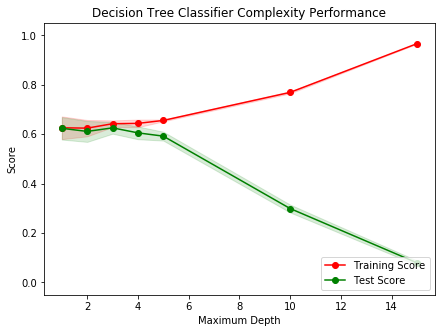

['int_rate', 'grade', 'inq_last_6mths', 'loan_amnt_int_rate', 'loan_amnt_inq_last_6mths', 'term_int_rate', 'int_rate_installment', 'int_rate_grade', 'int_rate_annual_inc', 'int_rate_zip_code', 'int_rate_inq_last_6mths', 'int_rate_mths_since_last_delinq', 'int_rate_mths_since_last_record', 'int_rate_open_acc', 'int_rate_revol_util', 'int_rate_total_acc', 'int_rate_initial_list_status', 'int_rate_application_type', 'int_rate_open_acc_6m', 'int_rate_open_act_il', 'int_rate_open_il_12m', 'int_rate_open_il_24m', 'int_rate_il_util', 'int_rate_open_rv_12m', 'int_rate_open_rv_24m', 'int_rate_max_bal_bc', 'int_rate_all_util', 'int_rate_inq_fi', 'int_rate_inq_last_12m', 'int_rate_acc_open_past_24mths', 'int_rate_bc_util', 'int_rate_mo_sin_old_il_acct', 'int_rate_mo_sin_old_rev_tl_op', 'int_rate_num_actv_bc_tl', 'int_rate_num_actv_rev_tl', 'int_rate_num_bc_sats', 'int_rate_num_bc_tl', 'int_rate_num_il_tl', 'int_rate_num_op_rev_tl', 'int_rate_num_rev_accts', 'int_rate_num_rev_tl_bal_gt_0', 'int_ra

In [9]:
# 
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    import warnings 
    warnings.filterwarnings('always')

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    #max_depth = np.arange(1,5)
    max_depth = [1, 2, 3, 4, 5, 10, 15]

    # Calculate the training and testing scores
    crit = 'entropy'
    #clf = DecisionTreeClassifier(criterion=crit, class_weight='balanced')
    clf = RandomForestClassifier(n_estimators=80, random_state=7, class_weight='balanced')

#     hls = [(100, 100, 50,)]
#     max_depth = [64, 128, 256, 512]

#     clf = MLPClassifier(verbose=0, random_state=0, max_iter=15, learning_rate_init=0.01,
#                        solver='adam', hidden_layer_sizes=(100, 100,))
    

#     train_scores, test_scores = validation_curve(clf, X, y, \
#                                                  param_name = "max_iter", \
#                                                  param_range = max_depth, \
#                                                  cv = 5, scoring = 'recall')
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    train_scores, test_scores = validation_curve(clf, X, y, \
                                             param_name = "max_depth", \
                                             param_range = max_depth, \
                                             cv = 3, 
                                             scoring = 'recall')
    

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    mx = np.argmax(test_mean)
    print("Test score D.T. criterion=", crit, "for max_depth=", max_depth[mx], "f2=", 
          round(test_mean[mx], 3), "std=", round(test_std[mx],3))
    
    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Classifier Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Test Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

#####################################################################################


# split data and train
y = df.loan_status
X = df.drop(columns='loan_status')

X = add_interactions(X)

x_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(X)
#x_scaled = QuantileTransformer(n_quantiles=10, random_state=0).fit_transform(X) 

#x_scaled = X

dfr = pd.DataFrame(x_scaled)
dfr.columns = X.columns.values
dfr.index = X.index.values
X_train, X_test, y_train, y_test = train_test_split(dfr, y, test_size=0.20, random_state=0)

# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
select = SelectKBest(k=100)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]


ModelComplexity(X_train_selected, y_train)

print(colnames_selected)

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=1)
#ftwo_scorer = make_scorer(fbeta_score, beta=2)
clf.fit(X_train_selected, y_train)


print(clf.feature_importances_)
y_predicted = clf.predict(X_test_selected)

print("recall:", round(recall_score(y_test, y_predicted), 4))

In [ ]:
# re-plot the normalized data
# for col in dfr.columns.values:
#     plot_box_hist2(X_train_selected, col, col, bins=50)

Best result: DT, GINI, cv=3, class_weight='balanced'
Test score for max_depth: 4 recall: 0.693 std: 0.011
Test score for max_depth: 3 recall: 0.707 std: 0.023, Poly Feat, 100 best

Test score R.F. criterion= entropy for max_depth= 5 f2= 0.236 std= 0.002
Test score D.T. criterion= entropy for max_depth= 1 f2= 0.226 std= 0.011

RandomForest: 

criterion= entropy for max_depth= 1 f2= 0.658 std= 0.044

            